In [ ]:
import numpy as np
from os import listdir, mkdir
from os.path import isfile, join
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from os import path
import os

In [ ]:
export_to = 'random-iter-1/'

In [ ]:
# If this code shows an error, the directory probably already exists
# In that case, increment the above export_to variable's value
# Example previous export_to = 'random-iter-4'. Set to 'random-iter-5'

mkdir(export_to)
print("Directory created")

In [ ]:
# Mapping from folder names (ZONFS) to set names (ABCDE)

mapping_set_to_dir = {
    'A': (0,'/content/random-iter-1/Z'),
    'B': (1,'/content/random-iter-1/O'),
    'C': (2,'/content/random-iter-1/N'),
    'D': (3,'/content/random-iter-1/F'),
    'E': (4,'/content/random-iter-1/S')
}


In [ ]:
file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [ ]:
file_lists[4]

['S077.txt',
 'S088.txt',
 'S081.txt',
 'S063.txt',
 'S097.txt',
 'S090.txt',
 'S084.txt',
 'S075.txt',
 'S098.txt',
 'S032.txt',
 'S082.txt',
 'S094.txt',
 'S092.txt',
 'S091.txt',
 'S053.txt',
 'S008.txt',
 'S026.txt',
 'S068.txt',
 'S022.txt',
 'S054.txt',
 'S021.txt',
 'S087.txt',
 'S009.txt',
 'S025.txt',
 'S086.txt',
 'S037.txt',
 'S007.txt',
 'S029.txt',
 'S048.txt',
 'S011.txt',
 'S018.txt',
 'S064.txt',
 'S033.txt',
 'S060.txt',
 'S003.txt',
 'S027.txt',
 'S070.txt',
 'S061.txt',
 'S005.txt',
 'S017.txt',
 'S093.txt',
 'S041.txt',
 'S083.txt',
 'S056.txt',
 'S100.txt',
 'S002.txt',
 'S079.txt',
 'S043.txt',
 'S001.txt',
 'S095.txt',
 'S042.txt',
 'S035.txt',
 'S059.txt',
 'S071.txt',
 'S039.txt',
 'S047.txt',
 'S099.txt',
 'S034.txt',
 'S030.txt',
 'S046.txt',
 'S058.txt',
 'S057.txt',
 'S040.txt',
 'S038.txt',
 'S085.txt',
 'S015.txt',
 'S004.txt',
 'S062.txt',
 'S044.txt',
 'S051.txt',
 'S073.txt',
 'S024.txt',
 'S045.txt',
 'S089.txt',
 'S014.txt',
 'S049.txt',
 'S012.txt',

In [ ]:
# Read every file from each data folder and store in the dictionary raw_dataset
# Please make sure there are no junk files present in the folder

raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        

        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [ ]:
raw_dataset['E'].shape

(100, 4097)

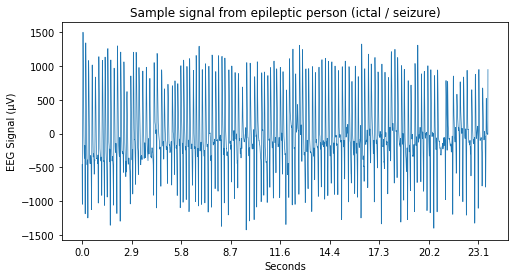

In [ ]:
#Visualizing the data
s = 'E'
index = 46

plot_title = ''
if (s in ['A', 'B']):
    plot_title = 'Sample signal from non-epileptic person'
elif (s in ['C', 'D']):
    plot_title = 'Sample signal from epileptic person (non-ictal / non-seizure)'
elif (s == 'E'):
    plot_title = 'Sample signal from epileptic person (ictal / seizure)'
else:
    print('s can be one of A,B,C,D,E')

plt.figure(figsize=(8,4))
plt.plot(raw_dataset[s][index], linewidth=0.7)
plt.title(plot_title)
plt.xlabel('Seconds')
plt.ylabel('EEG Signal (\u00B5V)')
tick_points = np.arange(0,9)*500 # each signal contains 4097 data points
plt.xticks(tick_points, np.round((tick_points/173.16)*10)/10) # mapping n-th data point to the time in seconds from the start of signal (173.16 Hz)
plt.show()

In [ ]:
#Data Augmentation
def create_augmented_dataset(raw_dataset, window_size = 512, stride = 64, verbose=False):
    """
    This function augments the dataset using sliding windows
    
    Parameters:
    raw_dataset: Dictionary containing a batch of examples for one set in each key
    window_size: Sliding window size
    stride: Steps by which sliding window moves and samples
    verbose: Display progress
    
    Returns:
    augmented_dataset: Dictionary containing a batch of smaller augmented examples than raw_dataset
    
    
    """
    
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():
        
        if (verbose):
            print('Processing set ' + s)

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    if (verbose):
        print('Done.')
    return augmented_dataset

In [ ]:
#Splitting of the data
#After randomly shuffling of the dataset, we take three sets, train (90%), dev (5%), and test (5%).
raw_dataset_train = { }
raw_dataset_dev = { }
raw_dataset_test = { }

for s,Xset_raw in raw_dataset.items():
    
    # randomly shuffle the data, just to make sure
    # that all train/dev/test sets come from same
    # distribution, (possibly not from a same person)
    np.random.shuffle(raw_dataset[s])
    
    ninety_percent = np.floor(0.9 * raw_dataset[s].shape[0]).astype(int)
    five_percent = np.floor(0.05 * raw_dataset[s].shape[0]).astype(int)
    
    # train set 0 - 89 (90%)
    raw_dataset_train[s] = raw_dataset[s][0:ninety_percent,:]
    
    # dev set 90 - 94 (5%)
    raw_dataset_dev[s] = raw_dataset[s][ninety_percent:ninety_percent+five_percent,:]
    
    # test set 95 - 99 (5%)
    raw_dataset_test[s] = raw_dataset[s][ninety_percent+five_percent:,:]

In [ ]:
print(raw_dataset_train['D'].shape)
print(raw_dataset_dev['A'].shape)
print(raw_dataset_test['C'].shape)

(90, 4097)
(5, 4097)
(5, 4097)


In [ ]:
#Scheme 1
print("Augmenting training data")
aug_dataset512_train = create_augmented_dataset(raw_dataset_train, window_size=512, stride=64, verbose=True)

print("Augmenting dev data")
aug_dataset512_dev = create_augmented_dataset(raw_dataset_dev, window_size=512, stride=256, verbose=True)

print("Augmenting test data")
aug_dataset512_test = create_augmented_dataset(raw_dataset_test, window_size=512, stride=256, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [ ]:
#Scheme 2
print('Augmenting training data')
aug_dataset1024_train = create_augmented_dataset(raw_dataset_train, window_size=1024, stride=128, verbose=True)

print ('Augmenting dev data')
aug_dataset1024_dev = create_augmented_dataset(raw_dataset_dev, window_size=1024, stride=512, verbose=True)

print('Augmenting test data')
aug_dataset1024_test = create_augmented_dataset(raw_dataset_test, window_size=1024, stride=512, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [ ]:
print(aug_dataset512_train['E'].shape)
print(aug_dataset512_dev['C'].shape)
print(aug_dataset512_test['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [ ]:
print(aug_dataset1024_train['E'].shape)
print(aug_dataset1024_dev['C'].shape)
print(aug_dataset1024_test['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


In [ ]:
#Saving the data
with h5.File(export_to + 'aug_dataset512.h5', 'w') as aug_file512:
    
    train512 = aug_file512.create_group('train')
    dev512 = aug_file512.create_group('dev')
    test512 = aug_file512.create_group('test')

    for s in aug_dataset512_train.keys():
        
        train512.create_dataset(s, data=aug_dataset512_train[s])
        dev512.create_dataset(s, data=aug_dataset512_dev[s])
        test512.create_dataset(s, data=aug_dataset512_test[s])

In [ ]:
aug_file512 = h5.File(export_to + 'aug_dataset512.h5', 'r')
print(aug_file512['train']['A'].shape)
print(aug_file512['dev']['C'].shape)
print(aug_file512['test']['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [ ]:
#Saving the data
with h5.File(export_to + 'aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])

In [ ]:
aug_file1024 = h5.File(export_to + 'aug_dataset1024.h5', 'r')
print(aug_file1024['train']['A'].shape)
print(aug_file1024['dev']['C'].shape)
print(aug_file1024['test']['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


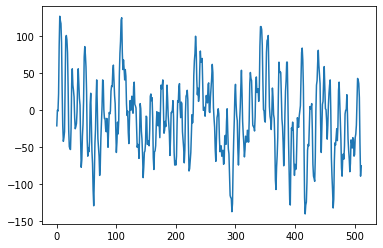

In [ ]:
#Visualizing augmented examples
s = 'B'
index = 400
plt.plot(aug_file512['train'][s][index])

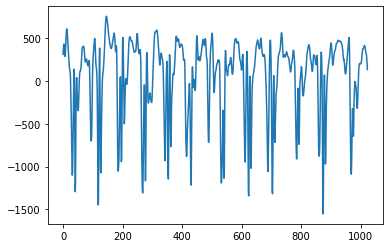

In [ ]:
s = 'E'
index = 175
plt.plot(aug_file1024['train'][s][index])

In [ ]:
aug_file512.close()
# aug_file1024.close()

In [ ]:
#One hot labels

import tensorflow as tf
tf.compat.v1.reset_default_graph
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow.compat.v1 as tf
# from tensorflow.python.framework import ops
# ops.reset_default_graph()

# For 3 class classification
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def read_dataset_and_one_hot_labels(filepath, setname, verbose=False):
    """
    Converts the dataset's labels into one-hot encoding
    
    Parameters:
    filepath: augmented dataset without one-hot encoding
    setname: either 'train', 'dev', or 'test'
    verbose: Display progress
    
    Returns:
    data: dataset with keys X_<setname>, Y_<setname>_classname, and Y_<setname> (one-hot labels). 
    """
    
    data = { }

    # Read dataset that is already stored in the file
    with h5.File(filepath, 'r') as aug_file:

        # classes are AB, CD, and E
        no_of_classes = 3

        for s in aug_file[setname].keys():
            
            if (verbose):
                print("Processing class: " + s)
            
            class_length = len(aug_file[setname][s])
            
            # go through each example in the class
            for i in range(class_length):
                
                if (verbose and i % (class_length / 5) == 0):
                    print((str)((int)(i / class_length * 100)) + '%')
                
                # create a big (combination of all classes) dataset
                # and also set their labels in a separate array
                if (('X_' + setname) in data):
                    data['X_' + setname] = np.append(data['X_' + setname], [aug_file[setname][s][i]], axis=0)
                    data['Y_' + setname + '_classname'] = np.append(data['Y_' + setname + '_classname'], [class_map[s]], axis=0)
                else:
                    data['X_' + setname] = np.array([aug_file[setname][s][i]])
                    data['Y_' + setname + '_classname'] = np.array([class_map[s]])


        
        if (verbose):
            print("Converting to one_hot")
            
        # use tensorflow one_hot function to convert labels into one_hot values
      
        # tf.compat.v1.reset_default_graph()
        
        tf.compat.v1.global_variables_initializer()

        # init = tf.global_variables_initializer()
        
        # with tf.compat.v1.Session() as sess:
        #     sess.run(init)
        #     data['Y_' + setname] = sess.run(tf.one_hot(data['Y_' + setname + '_classname'], depth=no_of_classes, axis=-1))
        with tf.compat.v1.Session() as sess:
            # sess.run(init)
            data['Y_' + setname] = sess.run(tf.one_hot(data['Y_' + setname + '_classname'], depth=no_of_classes, axis=-1))

        if (verbose):
            print("Done.")

    return data

In [ ]:
print("Converting training set to one hot")


Converting training set to one hot


In [ ]:
data512_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'train', verbose=True)

Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [ ]:
print("Converting dev set to one hot")
data512_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data512_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'test', verbose=True)

Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [ ]:
with h5.File(export_to + 'datafile512.h5', 'w') as datafile512:

    datafile512.create_dataset('X_train', data=data512_train['X_train'])
    datafile512.create_dataset('Y_train_classname', data=data512_train['Y_train_classname'])
    datafile512.create_dataset('Y_train', data=data512_train['Y_train'])
    
    datafile512.create_dataset('X_dev', data=data512_dev['X_dev'])
    datafile512.create_dataset('Y_dev_classname', data=data512_dev['Y_dev_classname'])
    datafile512.create_dataset('Y_dev', data=data512_dev['Y_dev'])
    
    datafile512.create_dataset('X_test', data=data512_test['X_test'])
    datafile512.create_dataset('Y_test_classname', data=data512_test['Y_test_classname'])
    datafile512.create_dataset('Y_test', data=data512_test['Y_test'])

In [ ]:
print("Converting training set to one hot")
data1024_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data1024_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data1024_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [ ]:
with h5.File(export_to + 'datafile1024.h5', 'w') as datafile1024:

    datafile1024.create_dataset('X_train', data=data1024_train['X_train'])
    datafile1024.create_dataset('Y_train_classname', data=data1024_train['Y_train_classname'])
    datafile1024.create_dataset('Y_train', data=data1024_train['Y_train'])
    
    datafile1024.create_dataset('X_dev', data=data1024_dev['X_dev'])
    datafile1024.create_dataset('Y_dev_classname', data=data1024_dev['Y_dev_classname'])
    datafile1024.create_dataset('Y_dev', data=data1024_dev['Y_dev'])
    
    datafile1024.create_dataset('X_test', data=data1024_test['X_test'])
    datafile1024.create_dataset('Y_test_classname', data=data1024_test['Y_test_classname'])
    datafile1024.create_dataset('Y_test', data=data1024_test['Y_test'])

In [ ]:
#Test set for voting accuracy
def augment_test_example(ex, window_size=512, stride=64):
    """
    Augments one dataset example with sliding window approach
    
    Used with test dataset to create multiple (typically 3) slices from one example
    The majority of the predictions on those 3 slices will be considered
    
    Parameters:
    ex: one example from dataset
    window_size: sliding window size
    stride: sliding window stride
    
    Returns:
    aug_ex: numpy array containing multiple smaller (augmented) examples
    """
    
    total_points = ex.shape[0]
    aug_ex = None
    
    # no. of examples generated from single training example using sliding window
    # = floor((total_points - window_size) / stride) + 1
    iterations = ((total_points - window_size) // stride) + 1

    for i in range(iterations):
        
        # window slice
        window_slice_from = i*stride
        window_slice_to = i*stride + window_size

        try:
            aug_ex = np.append(aug_ex, [ex[window_slice_from:window_slice_to]], axis=0)
        except:
            aug_ex = np.array([ex[window_slice_from:window_slice_to]])
    
    return aug_ex

In [ ]:
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def create_test_set_for_voting(testset, window_size=512, stride=64, divisions=2):
    """
    Augments whole test set in a way where each example contains multiple smaller slices
    
    The augmented dataset created by this function will be used by accuracy for voting measure
    Each example is divided into several divisions
    Each division consists of multiple slices (smaller examples)
    
    Parameters:
    testset: dictionary containing test examples for each class
    window_size: sliding window size
    stride: sliding window stride
    divisions: number of different examples to create from one example
    
    Returns:
    (new_test_set_X, new_test_set_Y, new_test_set_Y_onehot): numpy array of slices, labels, one-hot labels
    """
    
    new_test_set_X = None
    new_test_set_Y = []
    new_test_set_Y_onehot = None
    
    no_of_classes = 3
    identity = np.eye(no_of_classes)
    
    # loop over classes
    for c,class_data in testset.items():
        
        # loop over training examples
        for ex in class_data:
            
            for d in range(divisions):
                
                division_size = ex.shape[0] // divisions
            
                aug_ex = augment_test_example(ex[d*division_size:(d+1)*division_size], window_size=window_size, stride=stride)
                one_hot = identity[class_map[c]]

                try:
                    new_test_set_X = np.append(new_test_set_X, [aug_ex], axis=0)
                    new_test_set_Y_onehot = np.append(new_test_set_Y_onehot, [one_hot], axis=0)
                except:
                    new_test_set_X = np.array([aug_ex])
                    new_test_set_Y_onehot = np.array([one_hot])
                new_test_set_Y = np.append(new_test_set_Y, class_map[c])
        
    return new_test_set_X, new_test_set_Y, new_test_set_Y_onehot

In [ ]:
test_X_v_512, test_Y_v_512, test_Y_oh_v_512 = create_test_set_for_voting(raw_dataset_test, window_size=512, stride=256, divisions=4)

In [ ]:
test_X_v_1024, test_Y_v_1024, test_Y_oh_v_1024 = create_test_set_for_voting(raw_dataset_test, window_size=1024, stride=512, divisions=2)

In [ ]:
print(test_X_v_512.shape)
print(test_X_v_1024.shape)

(100, 3, 512)
(50, 3, 1024)


In [ ]:
with h5.File(export_to + 'testset_voting_512.h5', 'w') as testset_voting_512:
    
    testset_voting_512.create_dataset('X', data=test_X_v_512)
    testset_voting_512.create_dataset('Y', data=test_Y_v_512)
    testset_voting_512.create_dataset('Y_onehot', data=test_Y_oh_v_512)

In [ ]:
with h5.File(export_to + 'testset_voting_1024.h5', 'w') as testset_voting_1024:
    
    testset_voting_1024.create_dataset('X', data=test_X_v_1024)
    testset_voting_1024.create_dataset('Y', data=test_Y_v_1024)
    testset_voting_1024.create_dataset('Y_onehot', data=test_Y_oh_v_1024)

In [ ]:
#Reading data
dataset_relative_path = 'random-iter-1/'
print(dataset_relative_path)

random-iter-1/


In [ ]:
datafile = dataset_relative_path + 'datafile512.h5'

In [ ]:
with h5.File(datafile, 'r') as datafile:
    X_train = np.array(datafile['X_train'])
    Y_train = np.array(datafile['Y_train'])
    
    X_dev = np.array(datafile['X_dev'])
    Y_dev = np.array(datafile['Y_dev'])
    
    X_test = np.array(datafile['X_test'])
    Y_test = np.array(datafile['Y_test'])

In [ ]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [ ]:
X_train = make_dimensions_compatible(X_train)
X_dev = make_dimensions_compatible(X_dev)
X_test = make_dimensions_compatible(X_test)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(25650, 512, 1)
(25650, 3)


In [ ]:
#Normalization
X_train = X_train / 1000
X_dev = X_dev / 1000
X_test = X_test / 1000

In [ ]:
#Intialization
def initialize_parameters(parameter_shapes, parameter_values = {}):
    """
    Initializes weight parameters to build a neural network with tensorflow using Xaviar's initialization.
    The parameters are:
    parameter_shapes: a dictionary where keys represent tensorflow variable names, and values
    are shapes of the parameters in a list format
    Returns:
    params -- a dictionary of tensors containing parameters
    """
    
    params = { }
    
    for n,s in parameter_shapes.items():
        param = tf.compat.v1.get_variable(n, s, initializer = tf.keras.initializers.glorot_normal())
        params[n] = param
    
    for n,v in parameter_values.items():
        params[n] = v
    
    return params

In [ ]:
#Forward Propagation
def forward_propagation_cnn1(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.compat.v1.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.compat.v1.layers.batch_normalization(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.compat.v1.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.compat.v1.layers.batch_normalization(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    #Layer 3
    # CONV
    Z3 = tf.compat.v1.nn.conv1d(A2, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.compat.v1.layers.batch_normalization(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.compat.v1.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.compat.v1.layers.dense(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.keras.layers.Dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.compat.v1.layers.dense(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [ ]:
def forward_propagation_cnn3(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU DROPOUT) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.compat.v1.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.compat.v1.layers.batch_normalization(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.compat.v1.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.compat.v1.layers.batch_normalization(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    # Dropout
    A2_dropped = tf.keras.layers.Dropout(A2, keep_prob=DO_prob_middle_layer, is_training=training)
    
    #Layer 3
    # CONV
    Z3 = tf.compat.v1.nn.conv1d(A2_dropped, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.compat.v1.layers.batch_normalization(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.compat.v1.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.compat.v1.layers.dense(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.compat.v1.layers.Dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.compat.v1.layers.dense(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [ ]:
def forward_propagation_cnn8(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.compat.v1.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.compat.v1.layers.batch_normalization(Z1,training=training)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.compat.v1.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.compat.v1.layers.batch_normalization(Z2, training=training)
    # RELU
    A2 = tf.nn.relu(B2)
    
    # Flatten activations for FC layer
    A2_flat = tf.compat.v1.layers.flatten(A2)
    
    # Layer 3
    # FC
    A3 = tf.compat.v1.layers.dense(A2_flat, FC1_units, activation=tf.nn.relu)
    # Dropout
    A3_dropped = tf.nn.dropout(A3, keep_prob=DO_prob)
    
    # Layer 4
    # FC
    logits = tf.compat.v1.layers.dense(A3_dropped, output_classes, activation=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [ ]:
#Computing cost function
def compute_cost(X, Y, parameters, nn_key, training):
    
    """
    Apply softmax to the output classes and find cross entropy loss
    X - Input data
    Y - One-hot output class training labels
    
    Returns:
    cost - cross entropy loss
    """
    
    # FIXME: setting training=training causes problems during evaluation time
    if nn_key == 'cnn1':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn2':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn3':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn4':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn5':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn6':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn7':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn8':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    else:
        KeyError('Provided nn_key doesn\'t match with any model')
    
    cost = tf.compat.v1.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    
    return cost, Y_hat

In [ ]:
#Pre-requisites for training
#Create Placeholders
def create_placeholders(n_x, n_y):
    """
    Creates Tensorflow placeholders that act for input data and their labels
    
    Arguments:
    n_x - no. of features for X
    n_x - no. of classes for Y
    
    Returns:
    X - placeholder for data that contains input featurs,
        shape: (no. of examples, no. of features). No. of examples is set to None
    Y - placeholder for data that contains output class labels,
        shape (no. of examples, no. of classes). No. of examples is set ot None
    """
    tf.compat.v1.disable_eager_execution()
    X = tf.compat.v1.placeholder(dtype=tf.float32, name='X', shape=(None, n_x, 1))
    Y = tf.compat.v1.placeholder(dtype=tf.float32, name='Y', shape=(None, n_y))
    is_train = tf.compat.v1.placeholder(dtype=tf.bool,shape=(), name='is_train')
   
    return X,Y,is_train

In [ ]:
#Parameter shapes
def parameter_shapes(nn_key):
    """
    Get tha shapes of all parameters used in the model.
    Convolutional layer parameter shapes (filters) are in list format
    
    Arguments:
    nn_key - Provide the key for the neural network model used
    could be, 'cnn1', 'cnn2'
    
    Returns:
    param_shapes - dict that contains all the parameters as follows
    CONV1_W, CONV2_W, CONV3_W
    param_values:
    CONV1_Str, CONV2_Str, CONV3_Str,
    FC1_units, DO_prob, output_classes
    """
    
    param_shapes = {}
    param_values = {}
    
    do_prob = {
        'cnn1': 0.5,
        'cnn2': 0.3,
        'cnn3': 0.3,
        'cnn4': 0.9,
        'cnn5': 0.5,
        'cnn6': 0.7,
        'cnn7': 0.3,
        'cnn8': 0.3
    }
    
    do_prob_middle_layer = {
        'cnn1': 0,   # not used
        'cnn2': 0,   # not used
        'cnn3': 0.8,
        'cnn4': 0,   # not used
        'cnn5': 0,   # not used
        'cnn6': 0,   # not used
        'cnn7': 0,   # not used
        'cnn8': 0    # not used
    }
    
    fc1_units = {
        'cnn1': 20,
        'cnn2': 15,
        'cnn3': 15,
        'cnn4': 15,
        'cnn5': 20,
        'cnn6': 15,
        'cnn7': 15,
        'cnn8': 10
    }

    # Conv Layer 1 parameter shapes
    # No. of channels: 24, Filter size: 5, Stride: 3
    param_shapes['CONV1_W'] = [5, 1, 24]
    param_values['CONV1_Str'] = 3
    
    # Conv Layer 2 parameter shapes
    # No. of channels: 16, Filter size: 3, Stride: 2
    param_shapes['CONV2_W'] = [3, 24, 16]
    param_values['CONV2_Str'] = 2
    
    # Dropout after the convolutional layer 2
    # Not used in some cases
    param_values['DO_prob_middle_layer'] = do_prob_middle_layer[nn_key]
    
    # Conv Layer 3 parameter shapes
    # No. of channels: 8, Filter size: 3, Stride: 2
    param_shapes['CONV3_W'] = [3, 16, 8]
    param_values['CONV3_Str'] = 2
    
    # Fully connected layer 1 units = 20
    param_values['FC1_units'] = fc1_units[nn_key]
    
    # Dropout layer after fully connected layer 1 probability
    param_values['DO_prob'] = do_prob[nn_key]
    
    # Fully connected layer 2 units (also last layer)
    # No. of units = no. of output classes = 3
    param_values['output_classes'] = 3
    
    return param_shapes, param_values

In [ ]:
#Random mini-batches
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, window size) (m, n_x)
    Y -- output classes, of shape (number of examples, output classes) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
#Plotting costs
def plot_costs(costs, dev_costs, learning_rate, total_epochs):
    # plot the cost
    plt.plot(costs, color='blue', label='training')
    plt.plot(dev_costs, color='green', label='dev')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = %f\nTotal Epochs = %i" % (learning_rate, total_epochs))
    plt.legend()
    plt.show()

In [ ]:
#Training data

def model(X_train, Y_train, X_dev, Y_dev,
          learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True,
          save_session_path=None, model_file=None, restore_session=False, save_session_interval=5, max_to_keep=10,
          nn_key='cnn1'):
    """
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    restore_session -- load previously trained model whose path is derived from save_session_path and model_file
    max_to_keep -- no. of models to be saved
    nn_key -- can be one of cnn1, cnn2, cnn3 ... cnn8 (or the keys described in the literature)
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    # tf.compat.v1.InteractiveSession()
    tf.compat.v1.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x,_) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    dev_costs = []
    
    model_path = None
    if (save_session_path != None and model_file != None):
        model_path = save_session_path + model_file
    
    
    # Create Placeholders of the correct shape
    X, Y, is_train = create_placeholders(n_x, n_y)

    # Initialize parameters
    param_shapes, param_values = parameter_shapes(nn_key)
    parameters = initialize_parameters(param_shapes, param_values)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Prediction: Use Y_hat to compute the output class during prediction
    cost, Y_hat = compute_cost(X, Y, parameters, nn_key, is_train)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # For saving / restoring sesison when training for long
    epoch_counter = tf.compat.v1.get_variable('epoch_counter', shape=[], initializer=tf.compat.v1.keras.initializers.Zeros)
    counter_op = tf.compat.v1.assign_add(epoch_counter, 1)
    saver = tf.compat.v1.train.Saver(max_to_keep=max_to_keep)
    
    # Calculate the correct predictions
    predict_op = tf.compat.v1.argmax(Y_hat, 1)
    correct_prediction = tf.equal(predict_op, tf.compat.v1.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.compat.v1.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # For impementation of batch norm the tf.GraphKeys.UPDATE_OPS dependency needs to be added
    # see documentation on tf.contrib.layers.batch_norm
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Initialize all the variables globally
    init = tf.compat.v1.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess: #, tf.control_dependencies(update_ops):        
        if (restore_session == False and path.exists(save_session_path)):
            raise FileExistsError('Session already exists, either restore the session, or manually delete the files.')
        
        # restore the previous session if the path already exists
        if (model_path != None and restore_session==True):
            print("Restoring session...\n")
            saver.restore(sess, model_path)
            print("Previous epoch counter: %i\n\n" % epoch_counter.eval())
        else:
            sess.run(init)
        
        tf.compat.v1.train.export_meta_graph(model_path + '.meta') # save the model file (.meta) only once
        
        print("Cost at start: %f" % cost.eval({X: X_train, Y: Y_train, is_train: False}))
        print("Dev cost: %f" % cost.eval({X: X_dev, Y: Y_dev, is_train: False}))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                
                try:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, is_train: True})

                    epoch_cost += minibatch_cost / num_minibatches
                
                # Implement early stopping mechanism on KeyboardInterrupt
                except KeyboardInterrupt:
                    print("KeyboardInterrupt received. Stopping early")
                    plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())
                    return parameters
                
            
            if (epoch % save_session_interval == 0 and save_session_path != None):
                saver.save(sess, model_path, write_meta_graph=False)
            
            # Save the costs after each epoch for plotting learning curve
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                dev_cost = cost.eval({X: X_dev, Y: Y_dev, is_train: False})
                dev_costs.append(dev_cost)
                
                
            # Print the cost every epoch
            if print_cost == True and (epoch + 1) % 5 == 0:
                print ("\nCost after epoch %i: %f" % (epoch + 1, epoch_cost))
                print ("Dev cost after epoch %i: %f" % (epoch + 1, dev_cost))
                
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
                dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
                print("Train Accuracy:", train_accuracy)
                print("Dev Accuracy:", dev_accuracy)
            
            # increment the epoch_counter in case the session is saved
            # and restored later
            sess.run(counter_op)
                
                
        if (save_session_path != None):
            saver.save(sess, model_path, write_meta_graph=False)
        
        
        plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())

        # Calculate the correct predictions
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
                
        return parameters

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentatio

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future vers

Cost at start: 1.098207
Dev cost: 1.094568
Train Accuracy: 0.34101364
Dev Accuracy: 0.296

Cost after epoch 5: 1.002196
Dev cost after epoch 5: 1.079163
Train Accuracy: 0.48526317
Dev Accuracy: 0.464

Cost after epoch 10: 0.895682
Dev cost after epoch 10: 1.070030
Train Accuracy: 0.49929824
Dev Accuracy: 0.46933332

Cost after epoch 15: 0.806423
Dev cost after epoch 15: 1.059288
Train Accuracy: 0.49220273
Dev Accuracy: 0.49066666

Cost after epoch 20: 0.754701
Dev cost after epoch 20: 1.052921
Train Accuracy: 0.48635477
Dev Accuracy: 0.488

Cost after epoch 25: 0.695356
Dev cost after epoch 25: 1.052154
Train Accuracy: 0.48311892
Dev Accuracy: 0.46666667

Cost after epoch 30: 0.669440
Dev cost after epoch 30: 1.044256
Train Accuracy: 0.47524366
Dev Accuracy: 0.48533332

Cost after epoch 35: 0.652592
Dev cost after epoch 35: 1.040316
Train Accuracy: 0.4731384
Dev Accuracy: 0.48266667

Cost after epoch 40: 0.644645
Dev cost after epoch 40: 1.038120
Train Accuracy: 0.462846
Dev Accuracy: 

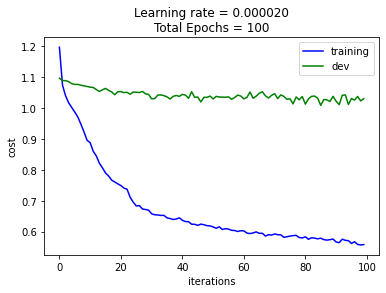

Train Accuracy: 0.4311111
Dev Accuracy: 0.42666668


In [ ]:
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=100,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn8_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn8')

In [ ]:
#Prediction and restoring saved model
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    tf.compat.v1.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.compat.v1.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        is_train = graph.get_tensor_by_name('is_train:0')
        
        epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
        print(epoch_counter.eval())

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            print('Accuracy: %f' % (y_hat_test == y_test).mean())
        

    return y_hat_test

In [ ]:
def predict_voting(X_test_voting, session_path, model_file):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file
    
    y_hat_test_voting = []

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        is_train = graph.get_tensor_by_name('is_train:0')

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.gather(classname, tf.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [ ]:
predictions = predict(X_dev, 'train/dataset-512-1/cnn8_lr-0.00002_mbs-128/', 'model.meta', Y_test_onehot=Y_dev)

print("\nPredicted values:")
print(predictions)

print("\nActual values:")
print(np.argmax(Y_test, 1))

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model
[( 88,) ( 21,) (150,) (186,) ( 17,) ( 86,) (  0,) (  0,) (200,) (196,)
 ( 76,) (153,) ( 17,) ( 86,) (  0,) (  0,) (  8,) (170,) (111,) ( 46,)
 ( 18,) ( 86,) (  0,) (  0,) (229,) (121,) (  9,) (254,) ( 34,) ( 81,)
 ( 60,) (242,) (  8,) ( 19,) (102,) (162,) ( 17,) ( 86,) (  0,) (  0,)
 ( 32,) (  1,) (125,) ( 46,) ( 18,) ( 86,) (  0,) (  0,) ( 64,) (  1,)
 (125,) ( 46,) ( 18,) ( 86,) (  0,) (  0,) ( 64,) (  1,) (125,) ( 46,)
 ( 18,) ( 86,) (  0,) (  0,) (  0,) (190,) (242,) (187,) ( 68,) (127,)
 (  0,) (  0,) ( 48,) ( 25,) (151,) ( 60,) (254,) (127,) (  0,) (  0,)
 ( 80,) ( 29,) (151,) ( 60,) (254,) (127,) (  0,) (  0,) (  0,) (  0,)
 (  0,) (  0,) (  0,) (  0,) (  0,) (  0,)]
Accuracy: 0.493333

Predicted values:
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  run_metadata)


In [ ]:
#Evaluating test set for accuracy with voting
testfile = dataset_relative_path + 'testset_voting_512.h5'
session_path = 'train/dataset-512-1/cnn8_lr-0.00002_mbs-128/'
model_file = 'model.meta'

with h5.File(testfile, 'r') as testfile:
    X_test_voting = testfile['X']
    X_test_voting = np.array(X_test_voting) / 1000
    y_test_voting = np.array(testfile['Y'])
    
    y_hat_test_voting = predict_voting(X_test_voting, session_path, model_file)
    
    print("Accuracy with voting: %f" % (y_test_voting == y_hat_test_voting).mean())

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model
Accuracy with voting: 0.400000


In [ ]:
print("Hat Test Voting",y_hat_test_voting)
print("Test Voting",y_test_voting)

Hat Test Voting [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0]
Test Voting [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


In [ ]:
def load_dataset(dataset_iter=1, window_size=512):
    global X_train, Y_train, X_dev, Y_dev, X_test, Y_test
    
    dataset_relative_path = 'random-iter-%d/' % dataset_iter
    
    datafile = dataset_relative_path + 'datafile%d.h5' % window_size

    with h5.File(datafile, 'r') as datafile:
        X_train = np.array(datafile['X_train'])
        Y_train = np.array(datafile['Y_train'])

        X_dev = np.array(datafile['X_dev'])
        Y_dev = np.array(datafile['Y_dev'])

        X_test = np.array(datafile['X_test'])
        Y_test = np.array(datafile['Y_test'])
        
        # setting the rank of the data to be compatible with 1d convolution functions
        # defined in tensorflow
        X_train = make_dimensions_compatible(X_train)
        X_dev = make_dimensions_compatible(X_dev)
        X_test = make_dimensions_compatible(X_test)
        
        # normalization
        X_train = X_train / 1000
        X_dev = X_dev / 1000
        X_test = X_test / 1000


In [ ]:
def get_session_path(dataset_iter=1, window_size=512, model_num=1, model_prefix='cnn', model_suffix='_lr-0.00002_mbs-128'):
    return ('train/dataset-%d-%d/' + model_prefix + '%d' + model_suffix + '/') % (window_size, dataset_iter, model_num)


In [ ]:
#Prediction
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    # tf.compat.v1.reset_default_graph()
    #tf.compat.v1.InteractiveSession() 

    loaded_graph = tf.Graph()
    graph = tf.compat.v1.get_default_graph()


    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.compat.v1.Session(graph=loaded_graph) as sess:
        loader = tf.compat.v1.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        
        
        X = loaded_graph.get_tensor_by_name('X:0')
        Y = loaded_graph.get_tensor_by_name('Y:0')
        is_train = loaded_graph.get_tensor_by_name('is_train:0')
        
#         epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
#         print(epoch_counter.eval())

        Y_hat = loaded_graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.compat.v1.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            acc = (y_hat_test == y_test).mean()
        

    return y_hat_test, acc

In [ ]:
#Prediction with majority voting on ensemble network
def predict_voting(X_test_voting, session_path, model_file):

    
    # tf.compat.v1.reset_default_graph()
    loaded_graph = tf.Graph()
    graph = tf.compat.v1.get_default_graph()


    checkpoint_path = session_path
    model_path = session_path + model_file       

    
    y_hat_test_voting = []

    with tf.compat.v1.Session(graph=loaded_graph) as sess:
        loader = tf.compat.v1.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        X = loaded_graph.get_tensor_by_name('X:0')
        is_train = loaded_graph.get_tensor_by_name('is_train:0')

        Y_hat = loaded_graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.compat.v1.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.compat.v1.gather(classname, tf.compat.v1.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [ ]:
#Accuracy measure
# Run the following code to call the above define predict method and check accuracy of the models

model_num = 8
window_size = 512
dataset_iters = (1, 2, 3, 4, 5, 6, 7, 8)

accuracies = np.array([])


In [ ]:
for dataset_iter in range(dataset_iters):
    load_dataset(dataset_iter=1, window_size=512)
    # print(load_dataset(dataset_iter=dataset_iter, window_size=window_size)
    predictions, acc = predict(X_test, get_session_path(dataset_iter=dataset_iters, window_size=512, model_num=model_num), 'model.meta', Y_test_onehot=Y_test)
    print(predictions)
    accuracies = np.append(accuracies, acc)

accuracies = accuracies * 100
print(accuracies)

print("Mean accuracy: %f" % accuracies.mean())

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model
[0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 2 0 2 2 0 1 1 0 0 0 1 2 0 1 2 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 2 1 0 1 0 0 1 1 1 1 0 2 0 2 0 1 2 0 2 0 0
 1 2 2 0 0]
[4213.33333333 4186.66666667 4160.         4160.         4080.
 4213.33333333 4133.33333333 4560.           41.06666667]
Mean accuracy: 3749.74814

In [ ]:
import numpy as np
#Single model accuracy with voting measure
model_num = 8
window_size = 512
dataset_iters = (1)

accuracies_voting = np.array([])
sensitivities_voting = np.array([])
specificities_voting = np.array([])
precisions_voting = np.array([])

In [ ]:
# for dataset_iter in dataset_iters:
dataset_relative_path = 'random-iter-1/'
testset_voting_512 = 'testset_voting_512.h5'
testfile = (dataset_relative_path + testset_voting_512) 
session_path = get_session_path(dataset_iter=1, window_size=512, model_num=model_num)
model_file = 'model.meta'

In [ ]:
with h5.File(testfile, 'r') as testfile:
        X_test_voting = testfile['X']
        X_test_voting = np.array(X_test_voting) / 1000
        y_test_voting = np.array(testfile['Y'])
        
        no_of_classes = 3

        y_hat_test_voting = np.array(predict_voting(X_test_voting, session_path, model_file))

        acc_voting_model = (y_test_voting == y_hat_test_voting)
        accuracies_voting = np.append(accuracies_voting, acc_voting_model)
        
        # specificity and sensitivity
        specificity = 0
        sensitivity = 0
        precision = 0
        for i in range(no_of_classes):
            specificity_vector = ((y_hat_test_voting != i) == (y_test_voting != i))[y_test_voting != i]
            sensitivity_vector = ((y_hat_test_voting == i) == (y_test_voting == i))[y_test_voting == i]
            precision_vector = ((y_hat_test_voting == i) == (y_test_voting == i))[y_hat_test_voting == i]
            
            specificity = specificity + specificity_vector.sum() / len(specificity_vector)
            sensitivity = sensitivity + sensitivity_vector.sum() / len(sensitivity_vector)
            precision = precision + precision_vector.sum() / len(precision_vector)
        
        specificity = specificity / no_of_classes
        sensitivity = sensitivity / no_of_classes
        precision = precision / no_of_classes
        
        specificities_voting = np.append(specificities_voting, specificity)
        sensitivities_voting = np.append(sensitivities_voting, sensitivity)
        precisions_voting = np.append(precisions_voting, precision)

INFO:tensorflow:Restoring parameters from train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model


In [ ]:
# Computing F-Score
Pre = precisions_voting.mean()
Sen = sensitivities_voting.mean()
F_Score = (2 * Pre * Sen) / (Pre + Sen)
        
accuracies_voting = accuracies_voting * 100
print("Accuracy with voting: ", accuracies_voting)
print("Mean accuracy with voting: %f" % accuracies_voting.mean())
print("\n\n")
print("Specifities: ", specificities_voting)
print("Mean specificity with voting: %f" % specificities_voting.mean())
print("\n\n")
print("Sensitivities: ", sensitivities_voting)
print("Mean sensitivity with voting: %f" % sensitivities_voting.mean())
print("Mean precision with voting: %f" % Pre)
print("Mean F-Score with voting: %f" % F_Score)
print("Standard deviation: %f" % accuracies_voting.std())

print("Actual labels:\n", y_test_voting)
print("\n\nPredictions:\n", y_hat_test_voting)


Accuracy with voting:  [100. 100. 100. 100. 100. 100. 100.   0. 100. 100. 100. 100. 100. 100.
 100. 100. 100.   0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 100. 100.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.
   0.   0.]
Mean accuracy with voting: 42.000000



Specifities:  [0.67777778]
Mean specificity with voting: 0.677778



Sensitivities:  [0.36666667]
Mean sensitivity with voting: 0.366667
Mean precision with voting: 0.531746
Mean F-Score with voting: 0.434040
Standard deviation: 49.355851
Actual labels:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

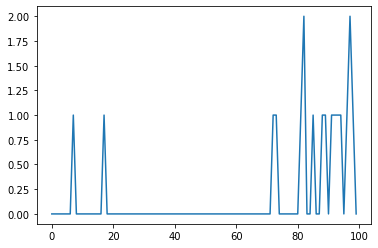

In [ ]:
plt.plot(y_hat_test_voting)


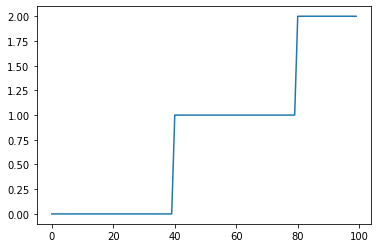

In [ ]:
plt.plot(y_test_voting)